<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Data Analytics Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block> 
        <font size=3>Homework 4</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:p.zilouchian@ut.ac.ir">Parham Zilouchian</a><br></font><br>
    </div>
</div>

# **Working with Database Systems**

## 1- EDA and Visualization

#### **Section 1. Just some points :)**

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2


def readData(year, season):
    dfDic = dict()
    newSeason = {"spring": "بهار","summer": "تابستان","fall": "پاییز","winter": "زمستان"}
    cols = ["year","season","province","total","men","women"]
    df = pd.read_excel(f"Datasets/Part1/veladat-{year}.xlsx", sheet_name=newSeason[season])
    dfDic[cols[2]] = list(df.loc[3:, "Unnamed: 1"]) #3 rows for skipping first of file that have not data
    dfDic[cols[3]] = (df.loc[3:, "Unnamed: 2"])
    dfDic[cols[4]] = (df.loc[3:, "Unnamed: 3"])
    dfDic[cols[5]] = (df.loc[3:, "Unnamed: 4"])
    dfDic[cols[1]] = [str(season)] * len(dfDic["province"])
    dfDic[cols[0]] = [year] * len(dfDic["province"])
    df = pd.DataFrame(dfDic)
    normalizer = Normalizer()
    df["province"] = df["province"].apply(normalizer.normalize)
    return df

def SQL(query, fetch):
        conn = psycopg2.connect(host="127.0.0.1", database="pouya", user="postgres", password="pass")
        cur = conn.cursor()
        cur.execute(query)
        if(fetch):
            data = cur.fetchall()
        else:
            data = None
        cur.close()
        conn.commit()
        return data

def createPopulationTable():
    query = """CREATE TABLE population (id INT GENERATED ALWAYS AS IDENTITY,province VARCHAR(255),population INT,PRIMARY KEY (id),CONSTRAINT constraint_a UNIQUE (province))"""
    SQL(query, fetch = False)

def createBirthsTable():
    query= """CREATE TABLE births (id INT GENERATED ALWAYS AS IDENTITY,province VARCHAR(255),year INT,season VARCHAR(100),total INT,men INT,women INT,PRIMARY KEY (id),CONSTRAINT constraint_b FOREIGN KEY(province) REFERENCES population(province),CONSTRAINT constraint_c UNIQUE (province, year, season, total),CONSTRAINT constraint_d UNIQUE (province, year, season, men),CONSTRAINT constraint_f UNIQUE (province, year, season, women))"""
    SQL(query, fetch = False)

def addRow(row, table, columns):
    values = ",".join([f"'{row[col]}'" for col in columns])
    query = f"INSERT INTO {table}({','.join(columns)}) VALUES ({values})"
    SQL(query, fetch = False)
    
def addPopulation():
    columns = ["province", "population"]
    df = pd.read_csv("Datasets/Part1/Iran_population.csv")
    df.columns = ['province', 'population']
    normalizer = Normalizer()
    df["province"] = df["province"].apply(normalizer.normalize)
    for index, row in df.iterrows():
        addRow(row, "population", columns)
    print("Population table is created!")

def addBirths():
    columns = ["province", "year", "season", "total", "men", "women"]
    for year in list(range(91, 100)) + [1400]:
        for season in ["spring", "summer", "fall", "winter"]:
            df = readData(year, season)
            for index, row in df.iterrows():
                row["year"] = int("13" + str(year)) if year != 1400 else 1400 
                addRow(row, "births", columns)
    print("Births table is created!")

createPopulationTable()
createBirthsTable()
addPopulation()
addBirths()
print("Done!")

Population table is created!
Births table is created!
Done!


## 2-Write Query using Psycopg2**

```
# This is formatted as code
```



##### **a. Total births**

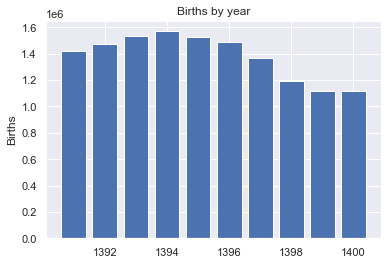

In [175]:
import seaborn as sns
sns.set_theme()

query = """SELECT year, sum(total) FROM births GROUP BY year ORDER BY year;"""
result = SQL(query, fetch = True)

df = pd.DataFrame(result, columns=["year", "births"])
plt.bar(df['year'], df['births'])
plt.title("Births by year")
plt.ylabel("Births")
plt.show()


in general, we can see the number of births are being reduced, we can see that till 1394 we have a local maximum meaning the number of births was increasing till then.

##### **b. Total births divide by gender**

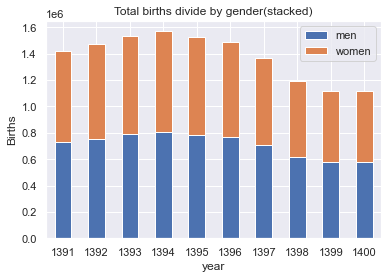

In [173]:
df = None
for i in ["men", "women"]:
    query = f"SELECT year, sum({i}) FROM births GROUP BY year ORDER BY year"
    if df is None:
        df = pd.DataFrame(SQL(query, fetch = True), columns=["year", i])
    else:
        df[i] = pd.DataFrame(SQL(query, fetch = True), columns=["year", i])[i]
df.plot(x="year" , kind="bar", rot=0, stacked = True)
plt.ylabel("Births")
plt.title("Total births divide by gender(stacked)")
plt.legend()
plt.show()

the overal of births based on gender is equally distributed as the gender is an independent variable meaning there's a 0.5 chance for being man/woman. the decreasing rate after 1394 also can be seen here.

##### **c. Most births in last five years**

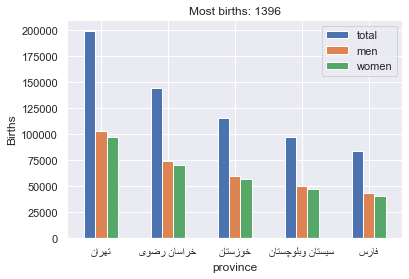

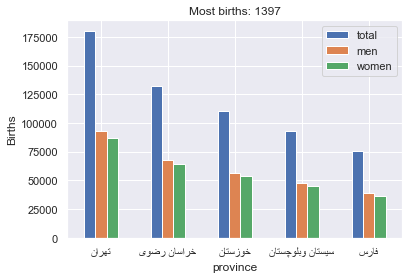

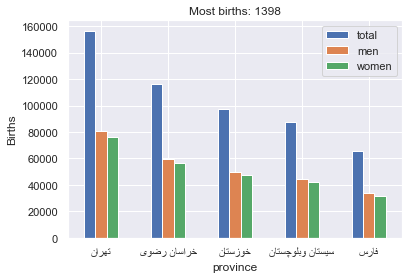

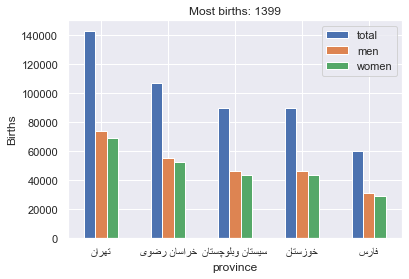

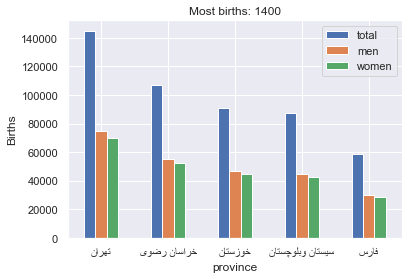

In [134]:
for year in range(1396, 1401):
    df = None
    for i in ["total", "men", "women"]:
        query = f"SELECT province, sum({i}) FROM births WHERE year={year} GROUP BY province ORDER BY sum({i}) DESC LIMIT 5;"
        if df is None:
            df = pd.DataFrame(SQL(query, fetch = True), columns=["province", i])
        else:
            df[i] = pd.DataFrame(SQL(query, fetch = True), columns=["province", i])[i]
        
    df["province"] = df["province"].apply(lambda x: get_display(arabic_reshaper.reshape(x))) #correct persian display
    df.plot(x="province" , kind="bar", rot=0)
    plt.title(f"Most births: {year}")
    plt.ylabel("Births")    
plt.show()

in this graph we can see the top five birth number. as expected tehran having the largest population, has the highest birth numbers. after that it is khorasan-e-razavi and at the end is fars. also khuzestan and baluchestan are 3rd and fourth except for the year "1399". also it can be understood that birth rate are males are somehow higher than female.

##### **d. Least births in last five years**

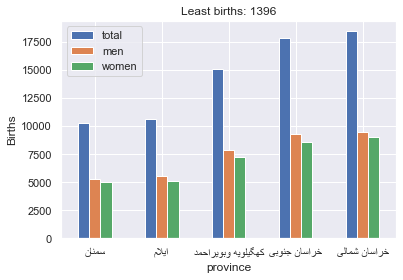

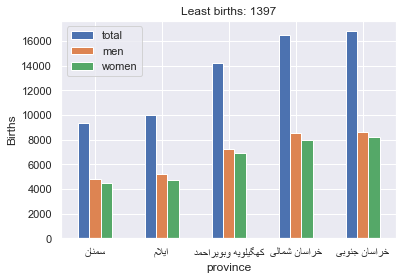

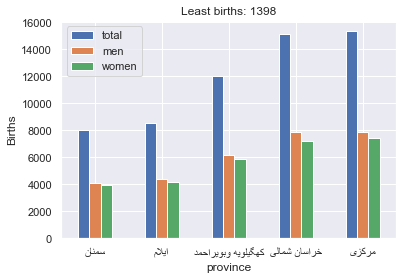

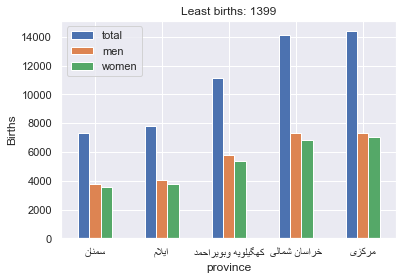

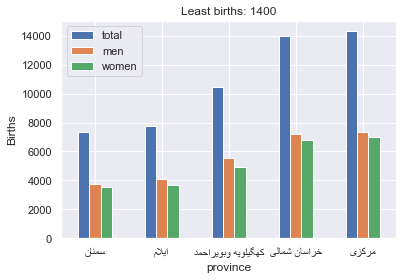

In [136]:
for year in range(1396, 1401):
    df = None
    for i in ["total", "men", "women"]:
        query = f"SELECT province, sum({i}) FROM births WHERE year={year} GROUP BY province ORDER BY sum({i}) ASC LIMIT 5;"
        if df is None:
            df = pd.DataFrame(SQL(query, fetch = True), columns=["province", i])
        else:
            df[i] = pd.DataFrame(SQL(query, fetch = True), columns=["province", i])[i]
        
    df["province"] = df["province"].apply(lambda x: get_display(arabic_reshaper.reshape(x))) #correct persian display
    df.plot(x="province" , kind="bar", rot=0)
    plt.title(f"Least births: {year}")
    plt.ylabel("Births")    
plt.show()

the top least in the birth number list is goint accordingly to semnan and elam kohgiluyeh and boyer-ahmad and northern khorasan and the last part is fliped, as it belonged to southern khorasan but in 1400 markazi has it.

##### **e. Most Birth-rate**

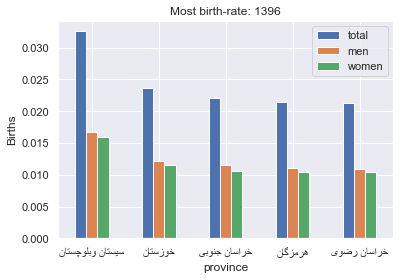

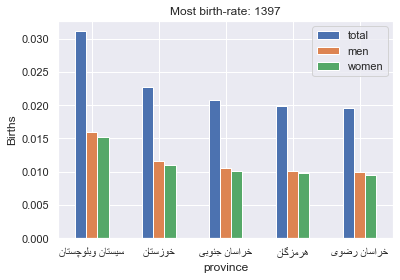

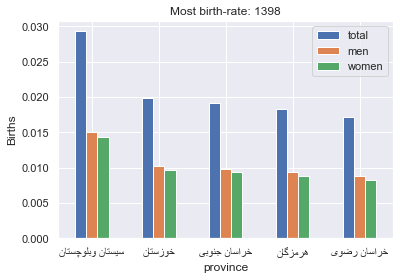

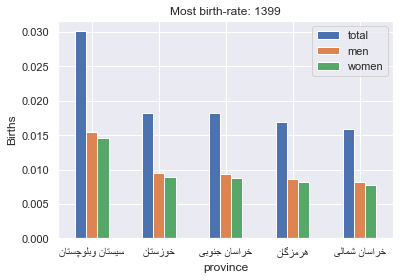

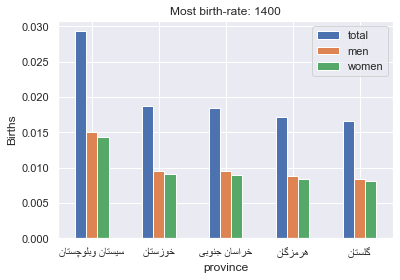

In [148]:
for year in range(1396, 1401):
    df = None
    for i in ["total", "men", "women"]:
        query = f"SELECT births.province, sum({i})::float/population.population FROM births INNER JOIN population ON births.province = population.province WHERE year={year} GROUP BY births.province, population.population ORDER BY sum({i})::float/population.population DESC LIMIT 5;"        
        if df is None:
            df = pd.DataFrame(SQL(query, fetch = True), columns=["province", i])
            df[i] = df[i].astype(float)
        else:
            df[i] = pd.DataFrame(SQL(query, fetch = True), columns=["province", i])[i]
            df[i] = df[i].astype(float)        
    df["province"] = df["province"].apply(lambda x: get_display(arabic_reshaper.reshape(x))) #correct persian display
    df.plot(x="province", kind="bar", rot=0)
    plt.ylabel("Births")
    plt.title(f"Most birth-rate: {year}")
plt.show()

in overal we can see more provinces with warm and humid weather in here, sistan-o-baluchestan, southern khorasan, hormozgan have always been on the list. and golstan has taken the last spot from noethern khorasan. an intersting fact is that despite having one of the least number of births, northern khorasan has a high rate of birth.

##### **f. Least Birth-rate**

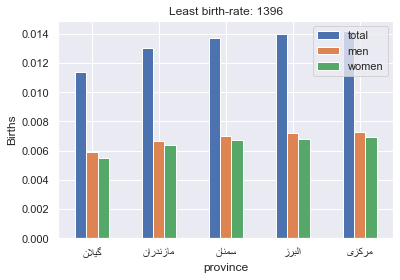

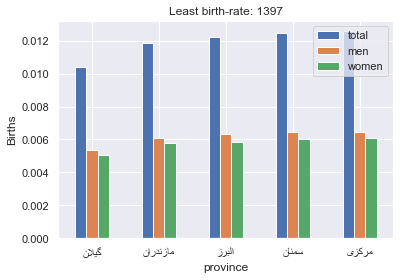

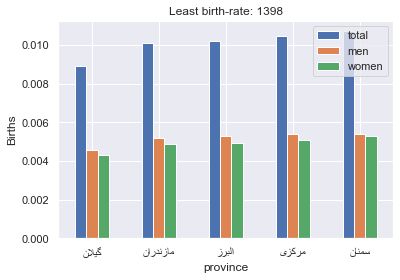

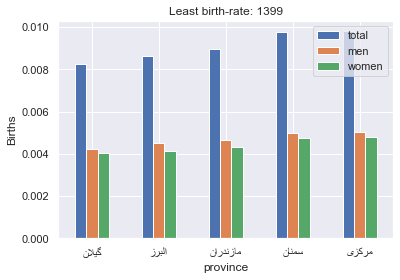

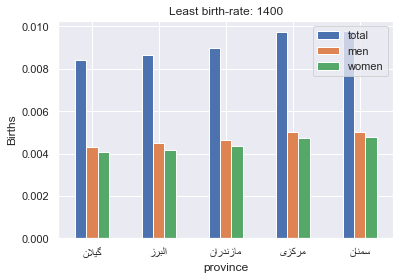

In [149]:
for year in range(1396, 1401):
    df = None
    for i in ["total", "men", "women"]:
        query = f"SELECT births.province, sum({i})::float/population.population FROM births INNER JOIN population ON births.province = population.province WHERE year={year} GROUP BY births.province, population.population ORDER BY sum({i})::float/population.population ASC LIMIT 5;"        
        if df is None:
            df = pd.DataFrame(SQL(query, fetch = True), columns=["province", i])
            df[i] = df[i].astype(float)
        else:
            df[i] = pd.DataFrame(SQL(query, fetch = True), columns=["province", i])[i]
            df[i] = df[i].astype(float)        
    df["province"] = df["province"].apply(lambda x: get_display(arabic_reshaper.reshape(x))) #correct persian display
    df.plot(x="province", kind="bar", rot=0)
    plt.ylabel("Births")
    plt.title(f"Least birth-rate: {year}")
plt.show()

in overal we can always see the same names with different orders, guilan has always had the least birth rate, also alborz, mazandaran, markazi and semnan can always be spotted on the list.

##### **g. Birth number and rate in each season!**

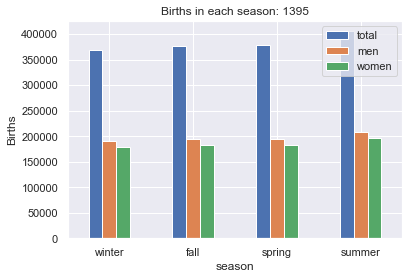

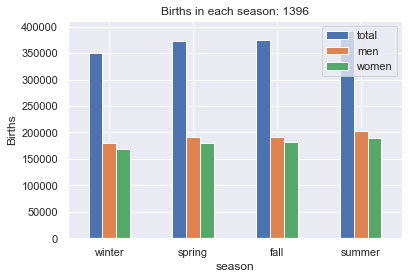

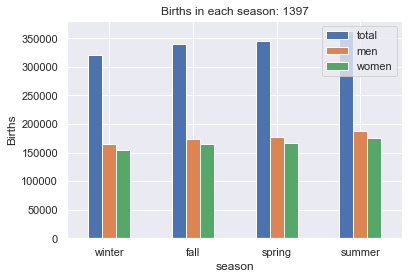

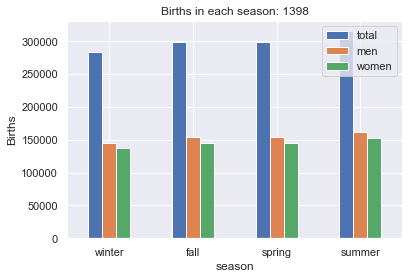

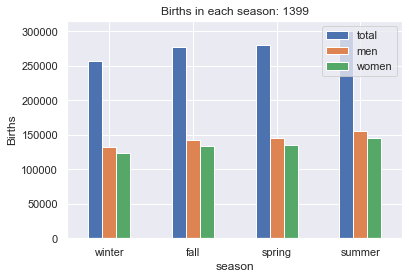

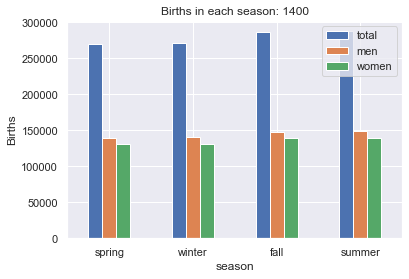

In [184]:
for year in range(1395, 1401):
    df = None
    for i in ["total", "men", "women"]:
        query = f"SELECT births.season, sum({i}) FROM births WHERE year={year} GROUP BY births.season ORDER BY sum({i})"
        if df is None:
            df = pd.DataFrame(SQL(query, fetch = True), columns=["season", i])
        else:
            df[i] = pd.DataFrame(SQL(query, fetch = True), columns=["season", i])[i]
    df.plot(x="season", kind="bar", rot=0)
    plt.ylabel("Births")
    plt.title(f"Births in each season: {year}")
    plt.show()
    


most births occur in summer ans least of them occur in winter as shown in the graphs above.


## 3-cursor.connect(**params)

in psycopg2, making multiple of the client side cursors should not have big complications except using some memory.Cursors are made for large data and being thread safe. If the dataset is too large to be practically handled on the client side, it is possible to create a server side cursor. Using this kind of cursor it is possible to transfer to the client only a controlled amount of data, so that a large dataset can be examined without keeping it entirely in memory. It is possible to create a WITH HOLD cursor (Default is WITHOUT HOLD) by specifying a True value for the withhold parameter to cursor() or by setting the withhold attribute to True before calling execute() on the cursor. It is extremely important to always close() such cursors, otherwise they will continue to hold server-side resources until the connection will be eventually closed. "connection.cursor()" is used to creat cursors,they are bound to the connection for the entire lifetime and all the commands are executed in the context of the database session wrapped by the connection. also, cursor does not have any method called "connect"! 



## **Part2 - Working with QGIS**

#### **Section A: Load Data**

In [152]:
def postGIS(query, fetch):
        conn = psycopg2.connect(host="127.0.0.1", database="postgis", user="postgres", password="pass")
        cur = conn.cursor()
        cur.execute(query)
        if(fetch):
            data = cur.fetchall()
        else:
            data = None
        cur.close()
        conn.commit()
        return data

paths = ["Datasets/Part2_QGIS/Iran_Country.sql", "Datasets/Part2_QGIS/Iran_States.sql","Datasets/Part2_QGIS/Iran_County.sql", "Datasets/Part2_QGIS/Iran_Inland_Water.sql"]
         
for path in paths:       
    database = open(path, 'r').read()
    postGIS(database, fetch = False)
print("Database is loaded!")


Database is loaded!


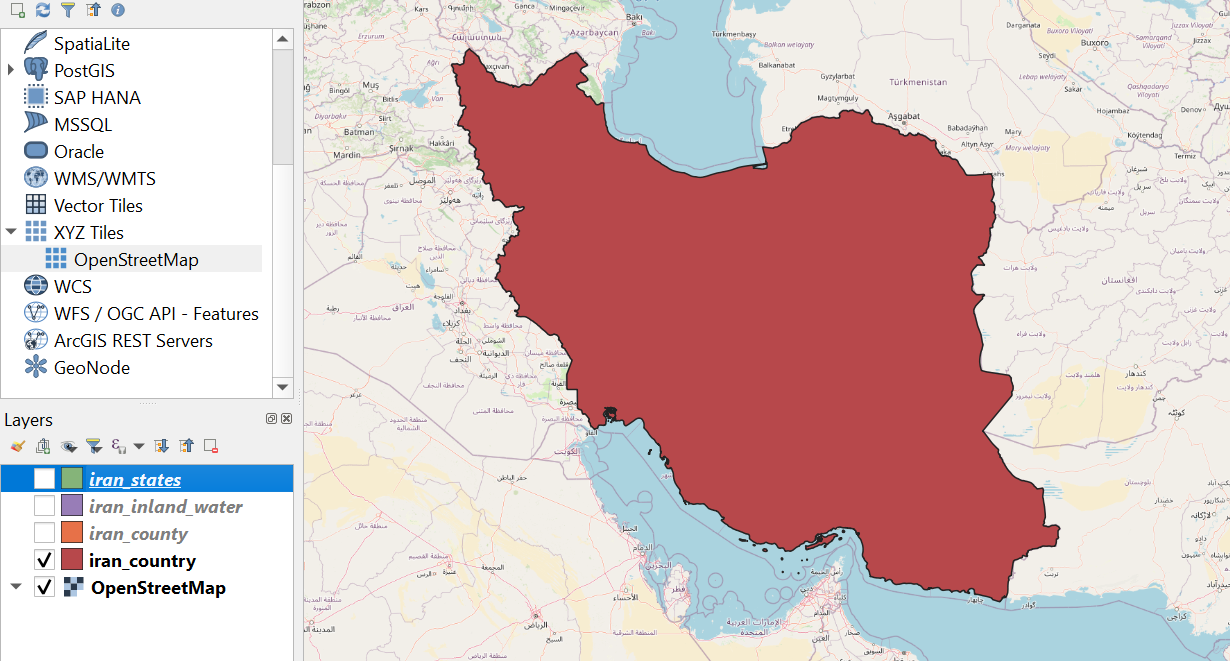

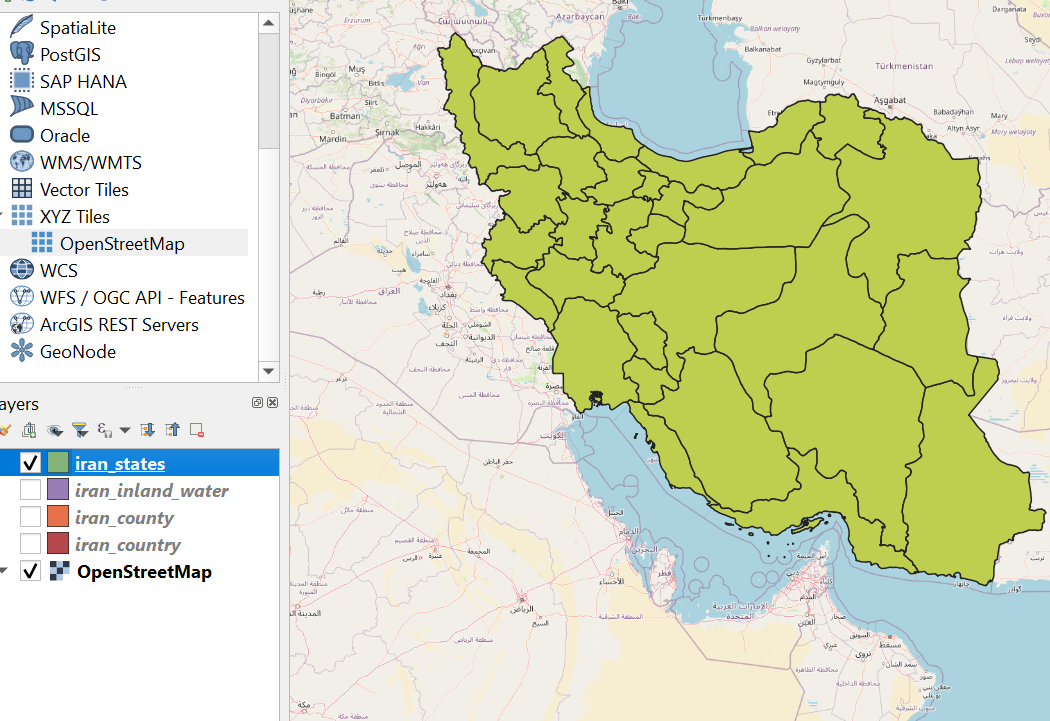

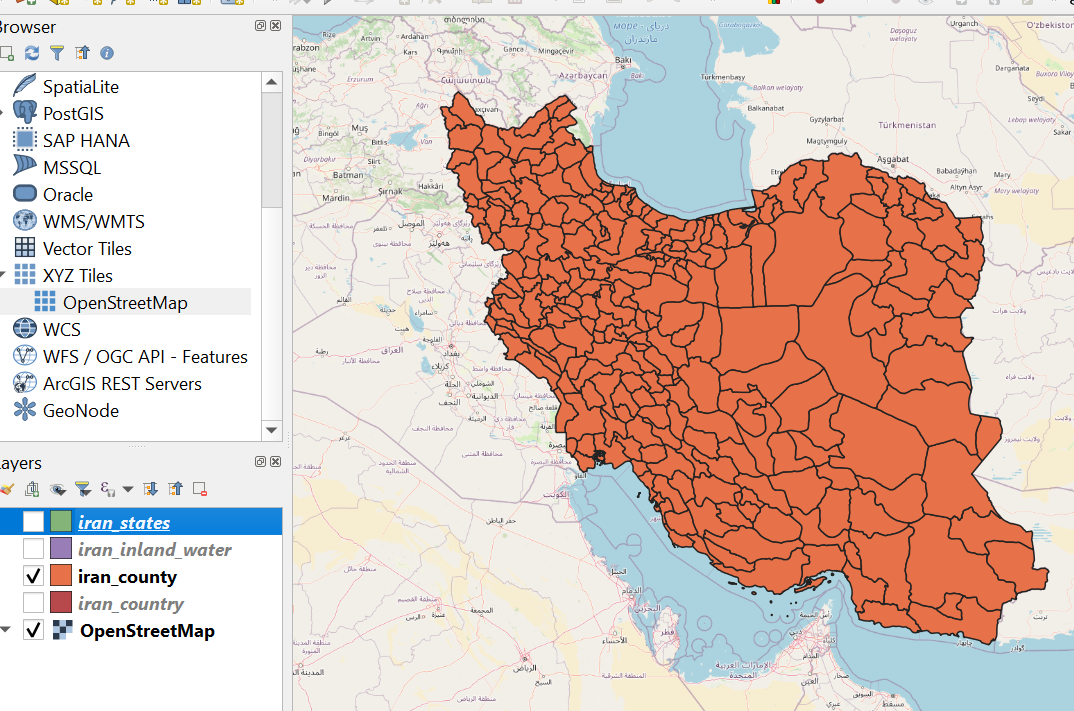

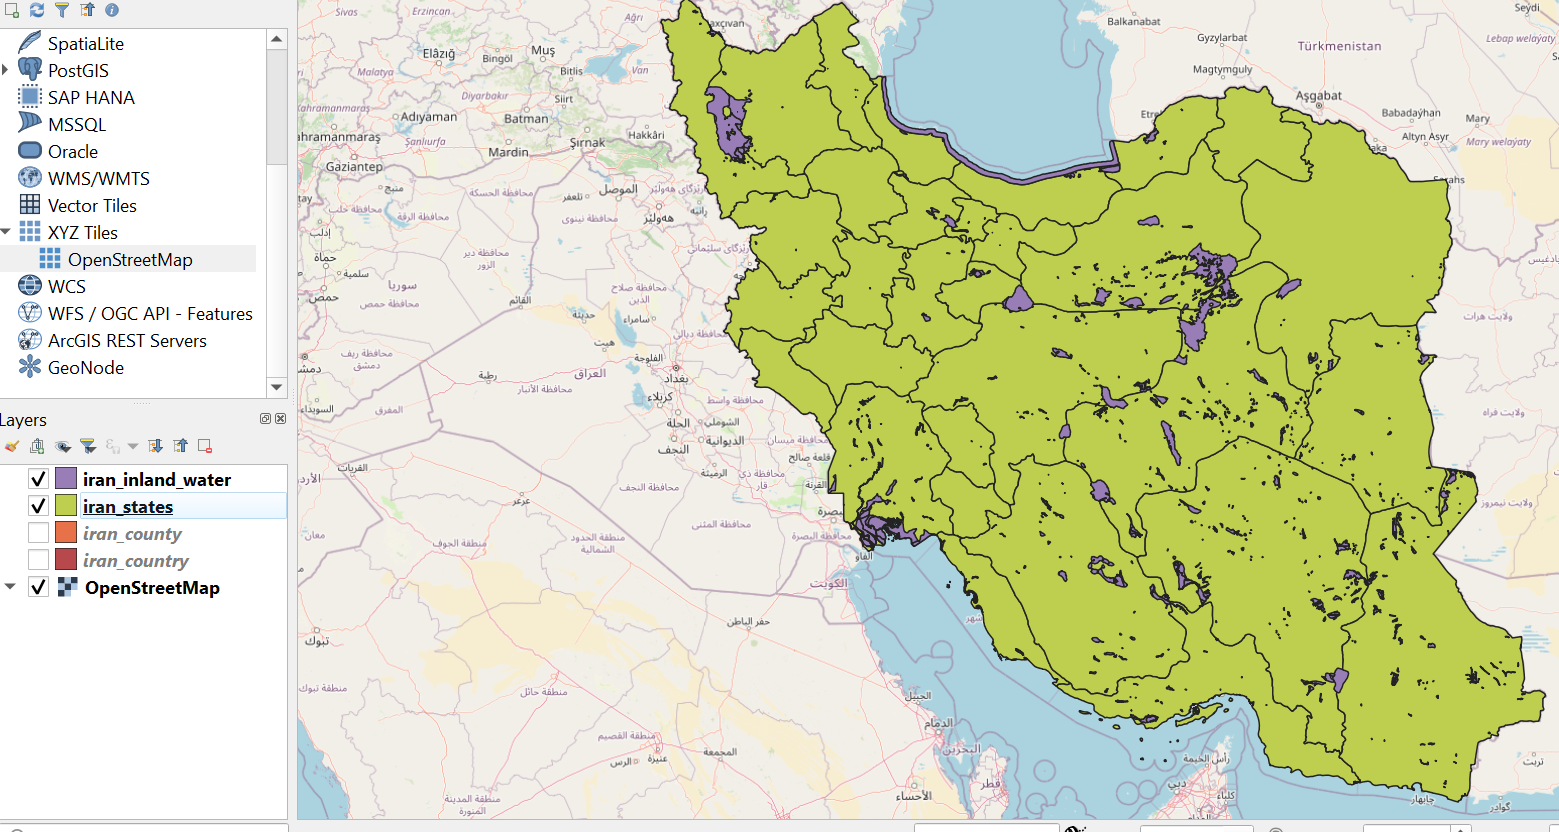

#### **Section B: Answer Questions**

In [155]:
query = "SELECT name_0, name_1, name_2 FROM iran_county WHERE ST_Intersects(iran_county.wkb_geometry, ST_SetSRID(ST_Point(51.3380650, 35.6997300), 4326));"  
print(postGIS(query, fetch=True))

[('Iran', 'Tehran', 'Theran')]


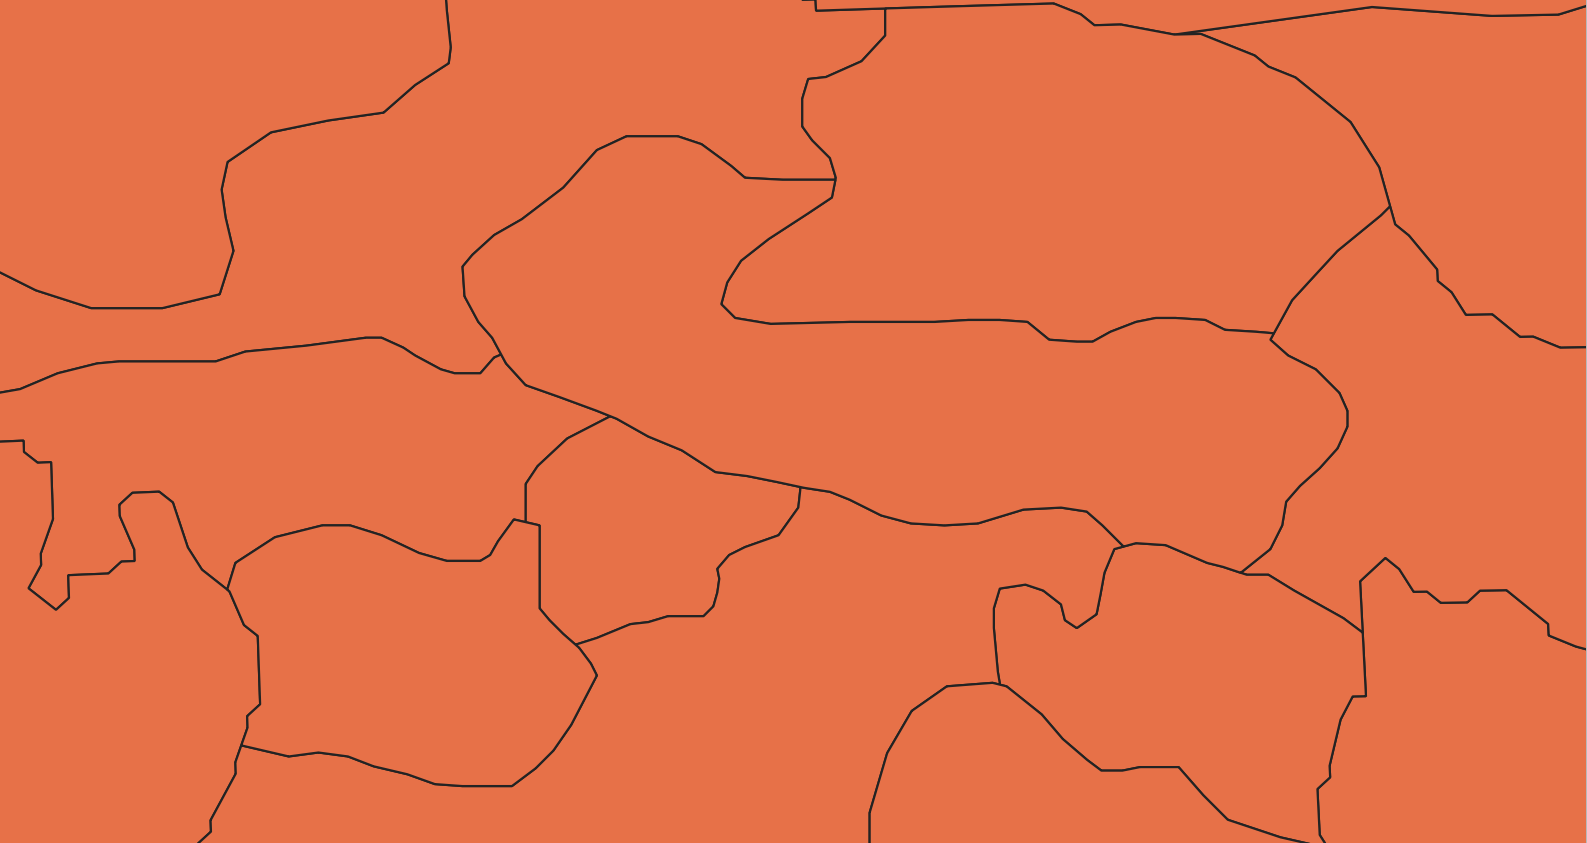

In [161]:
query = "SELECT name_0, name_1, name_2 FROM iran_county WHERE ST_Intersects(iran_county.wkb_geometry, ST_SetSRID(ST_Point(52.8904157, 29.9351594), 4326))"  
print(postGIS(query, fetch=True))

[('Iran', 'Fars', 'Marvdasht')]


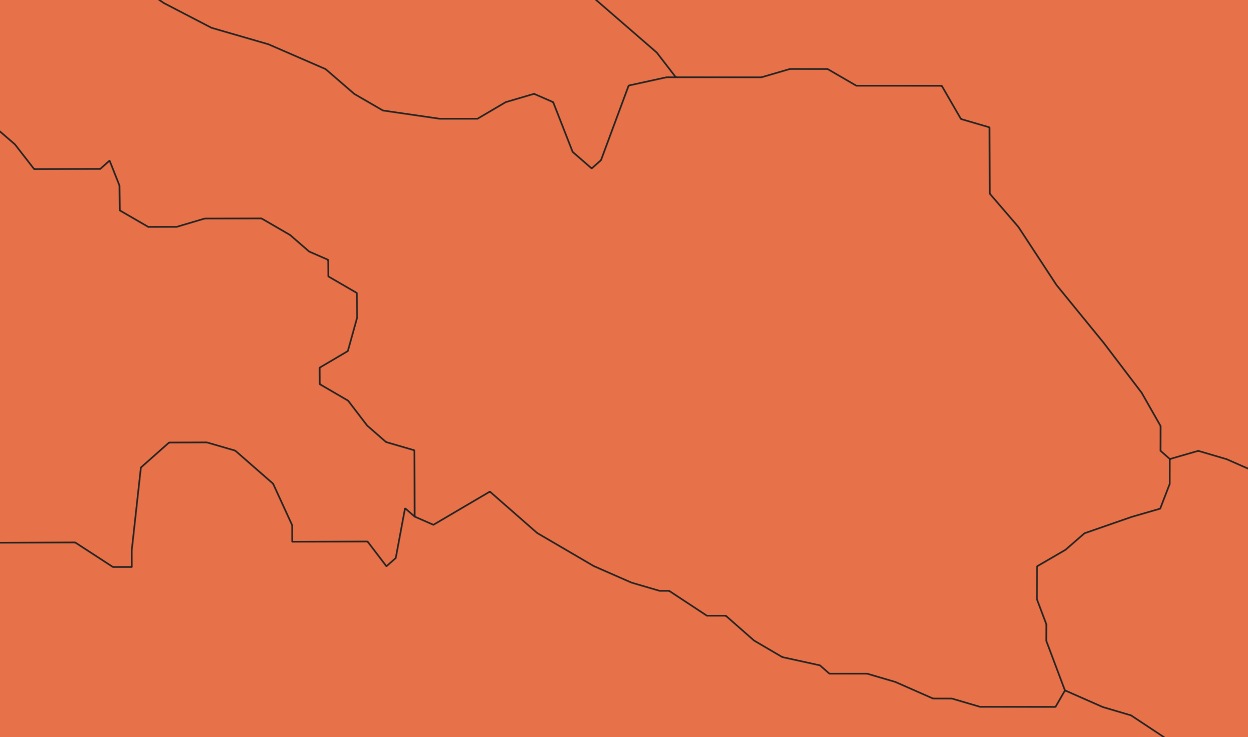

### c


In [160]:
query = "SELECT iran_county.name_0, iran_county.name_1, iran_county.name_2, iran_inland_water.name FROM iran_county, iran_inland_water WHERE ST_Intersects(iran_inland_water.wkb_geometry, ST_SetSRID(ST_Point(51.270365, 35.728517), 4326)) and  ST_Intersects(iran_county.wkb_geometry, ST_SetSRID(ST_Point(51.270365, 35.728517), 4326));"  
print(postGIS(query, fetch=True))


[('Iran', 'Tehran', 'Theran', 'UNK')]


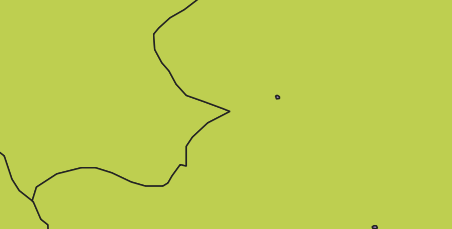

In [158]:
query = "SELECT iran_county.name_0, iran_county.name_1, iran_county.name_2, iran_inland_water.name FROM iran_county, iran_inland_water WHERE ST_Intersects(iran_inland_water.wkb_geometry, ST_SetSRID(ST_Point(45.4533, 37.6186), 4326)) and  ST_Intersects(iran_county.wkb_geometry, ST_SetSRID(ST_Point(45.4533, 37.6186), 4326));"
print(postGIS(query, fetch=True))

[('Iran', 'East Azarbaijan', 'Shabestar', 'DARYACHEH-YE ORUMIYEH')]


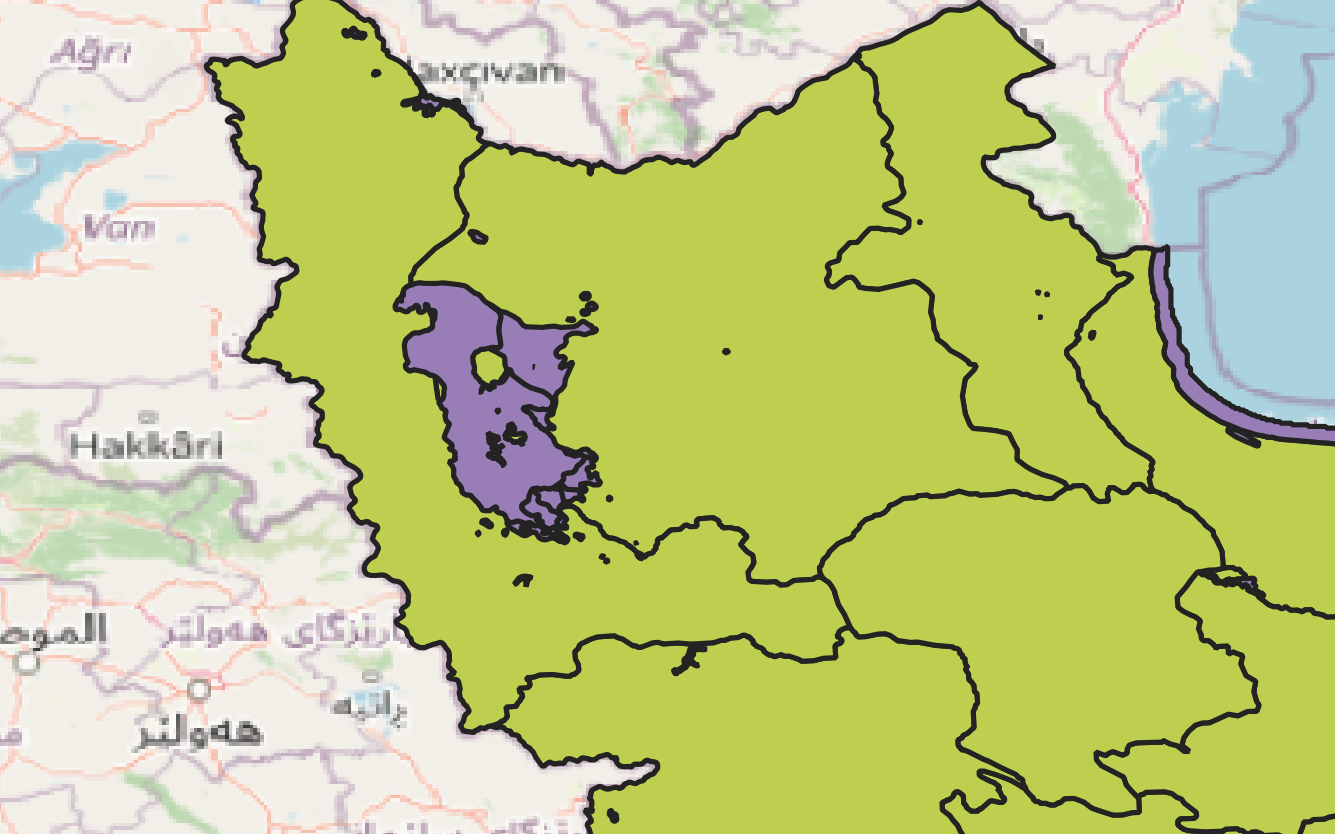